In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from scipy.signal import find_peaks


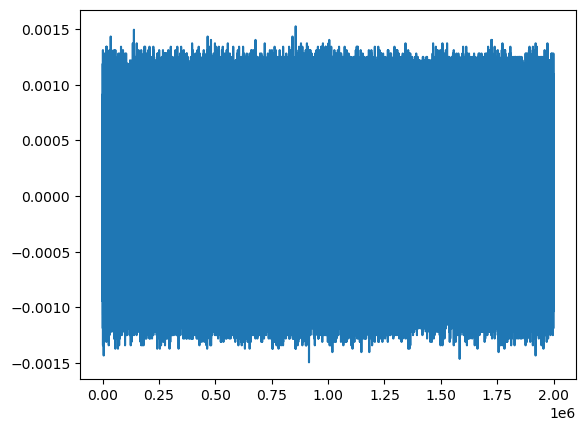

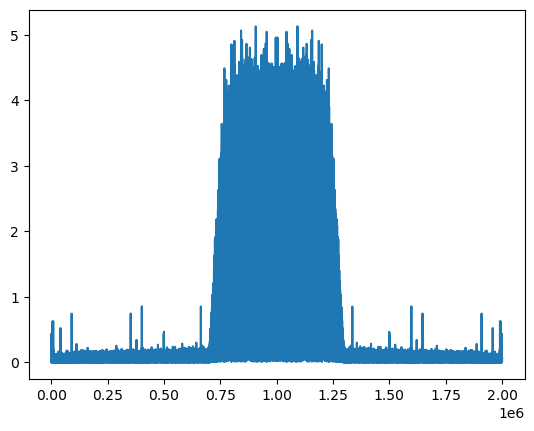

In [4]:
file1_name="f433_snr20_QPSK/file_1.dat"
file2_name="f433_snr20_QPSK/file_2.dat"
sampling_rate=2*1e6
sample_time=1/sampling_rate
N=10000000
fd=open(file1_name,"rb")
fd2=open(file2_name,"rb")
data=np.fromfile(fd,dtype=np.complex64,count=N)
data2=np.fromfile(fd2,dtype=np.complex64,count=N)
plt.plot(np.real(data[5000000:7000000]))
plt.show()
plt.plot(abs(np.fft.fftshift(np.fft.fft(np.real(data)[5000000:7000000]))))

In [5]:
signal_with_bursts=np.concatenate((data[5000000:5500000],np.array([0 for i in range(500000)]),data[6000000:6500000],np.array([0 for i in range(500000)])))
print(len(signal_with_bursts))

2000000


In [6]:
#Getting IQ samples of WIFI in the form {channel_num:{[I samples],[Qsamples]}\
Wifi_symbols={1:{'I':np.real(data[5000000:7000000]),'Q':np.imag(data[5000000:7000000])},2:{'I':np.real(signal_with_bursts),'Q':np.imag(signal_with_bursts)}}

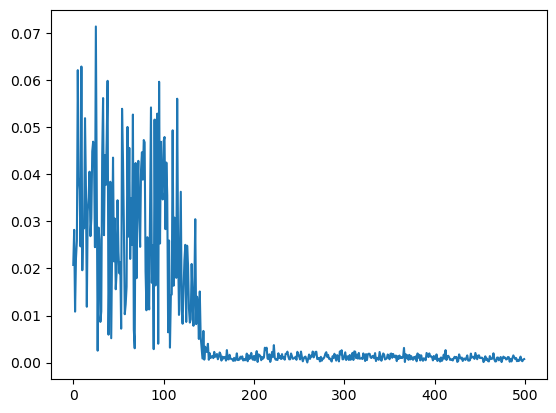

In [7]:
#Create 2-D stft array for each channel

num_samples_per_fft=1000
num_fft=2000

Per_channel_time_frequency_spectrum={}

for channel in Wifi_symbols:
    Per_channel_time_frequency_spectrum[channel]={}
    I_f_t_spectrum=[]
    Q_f_t_spectrum=[]
    for i in range(num_fft-1):
        #print((i+1)*num_samples_per_fft)
        I_f_t_spectrum.append(abs(np.fft.fft(Wifi_symbols[channel]['I'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
        Q_f_t_spectrum.append(abs(np.fft.fft(Wifi_symbols[channel]['Q'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
    Per_channel_time_frequency_spectrum[channel]['I']=np.array(I_f_t_spectrum)
    Per_channel_time_frequency_spectrum[channel]['Q']=np.array(Q_f_t_spectrum)

#print(Per_channel_time_frequency_spectrum)
plt.plot(Per_channel_time_frequency_spectrum[1]['I'][0])        

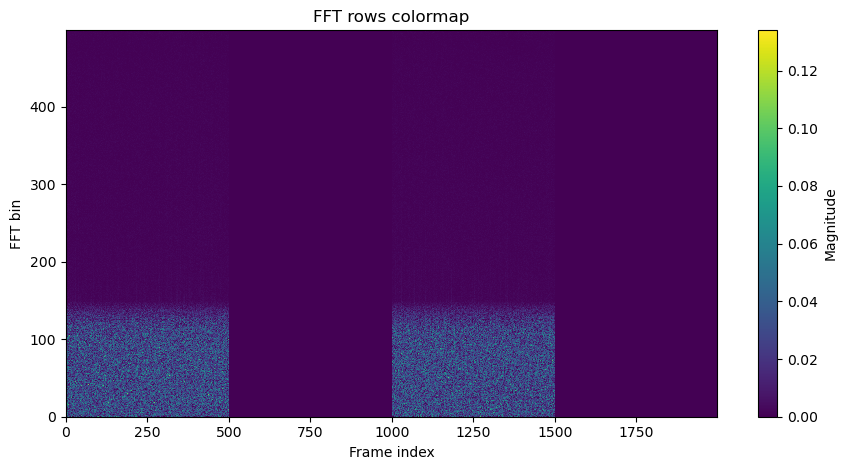

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fft_rows_colormap_freq_on_y(M, fs=None, freq_axis=None, title="FFT rows colormap",
                                     cmap="viridis", vmin=None, vmax=None, log_scale=False):
    """
    M shape: (n_rows, n_bins). Each row is an FFT over frequency bins.
    This plots frequency on Y (vertical) and row index on X (horizontal).
    """
    M = np.asarray(M)
    Mmag = np.abs(M) if np.iscomplexobj(M) else M
    Mdisp = 20*np.log10(Mmag + np.finfo(float).eps) if log_scale else Mmag

    n_rows, n_bins = Mdisp.shape

    # X-axis: row index (or time frame index)
    x = np.arange(n_rows)

    # Y-axis: frequency bins or Hz
    if freq_axis is not None:
        y = np.asarray(freq_axis)
    elif fs is not None:
        # If these are rfft bins, use 0..fs/2; for full fft use -fs/2..fs/2 accordingly
        y = np.linspace(0, fs/2, n_bins)
    else:
        y = np.arange(n_bins)

    # Transpose so that frequency (bins) maps to vertical axis as desired
    Z = Mdisp.T

    fig, ax = plt.subplots(figsize=(9, 4.8))
    im = ax.imshow(
        Z,
        aspect='auto',
        origin='lower',                   # put lowest frequency at bottom
        extent=[x[0], x[-1], y[0], y[-1]],# extent = [xmin, xmax, ymin, ymax]
        cmap=cmap, vmin=vmin, vmax=vmax,
        interpolation='nearest'
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Magnitude (dB)' if log_scale else 'Magnitude')

    ax.set_xlabel('Frame index')
    ax.set_ylabel('Frequency (Hz)' if (fs is not None or freq_axis is not None) else 'FFT bin')
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

fig,ax=plot_fft_rows_colormap_freq_on_y(Per_channel_time_frequency_spectrum[2]['I'])
plt.show()

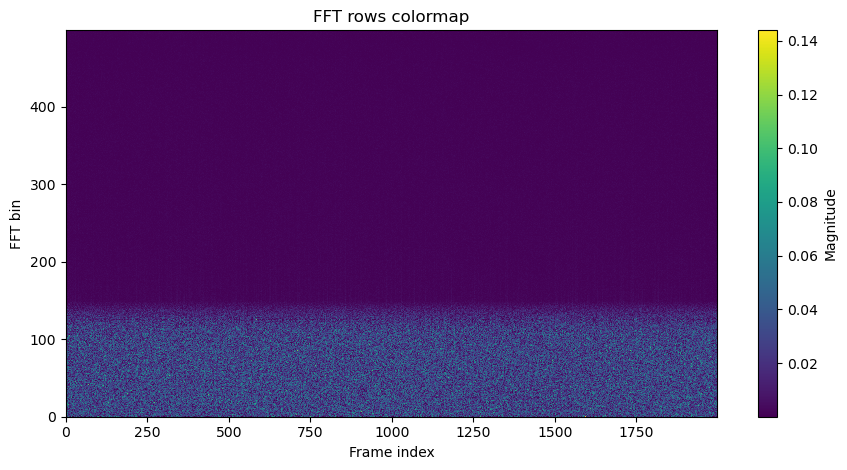

In [7]:
fig,ax=plot_fft_rows_colormap_freq_on_y(Per_channel_time_frequency_spectrum[1]['I'])
plt.show()

In [12]:
def find_coh_time(time_domain_signal,threshold=0.001):
    autocorr = np.correlate(time_domain_signal,time_domain_signal, mode='full')
    mid = len(autocorr) // 2
    autocorr = autocorr[mid:]  # only positive lags
    #mean_autocorr=np.mean(autocorr)

    #I assume that if t_coh is very large then I will set it to 100ms which is twice the number of samples per t_coh I have chosen
    t_coh_samples=len(autocorr)*2
    for i in range(len(autocorr)):
        if autocorr[i]<=threshold:
            t_coh_samples=i
    return t_coh_samples

def find_coherence_time_per_channel(Wifi_symbol_dict):
    num_samples_per_coherence_detection=int(50*1e-3/sample_time) #We need 50ms data for this
    t_coh_dict={}
    for channel in Wifi_symbol_dict:
        t_coh_dict[channel]={'I':0,'Q':0}
        i=0
        number_samples=len(Wifi_symbol_dict[channel]['I'])
        t_coh_distribution_arr_I=[]
        t_coh_distribution_arr_Q=[]
        while num_samples_per_coherence_detection*i<number_samples:
            #normalised_I_samples=Wifi_symbol_dict[channel]['I']
            I_curr_samples=Wifi_symbol_dict[channel]['I'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
            Q_curr_samples=Wifi_symbol_dict[channel]['Q'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
            amin = np.min(I_curr_samples)
            amax = np.max(I_curr_samples)
            normalised_I_samples= (I_curr_samples- amin) / (amax - amin + 1e-12)  # eps avoids divide-by-zero if all equal
            t_coh_distribution_arr_I.append(find_coh_time(normalised_I_samples))
            bmin = np.min(Q_curr_samples)
            bmax = np.max(Q_curr_samples)
            normalised_Q_samples= (Q_curr_samples - bmin) / (bmax - bmin + 1e-12)  # eps avoids divide-by-zero if all equal
            t_coh_distribution_arr_Q.append(find_coh_time(normalised_Q_samples))
            i+=1
            print(i)
        
        t_coh_dict[channel]['I']=np.mean(t_coh_distribution_arr_I)
        t_coh_dict[channel]['Q']=np.mean(t_coh_distribution_arr_Q)
    
    return t_coh_dict

print(find_coherence_time_per_channel(Wifi_symbols))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
{1: {'I': 200000.0, 'Q': 200000.0}, 2: {'I': 149999.5, 'Q': 149999.5}}


In [13]:
# multi armed bandit to select next channel to scan
int(50*1e-3/sample_time)

100000

In [27]:
# each channel is one arm
N = 2 # number of arms
num_samples_per_block=num_samples_per_fft
arms_with_reward = {}
arm_last_played_time = {}
arm_mean_time = {}
arm_stddev = {}
arm_rounds_played = {}
for i in range(1, N+1):
    arms_with_reward[i] = 0
    arm_last_played_time[i] = 0
    arm_mean_time[i] = min(mean_std_dev_each_channel[i]['I'][0],mean_std_dev_each_channel[i]['Q'][0])*num_samples_per_fft
    arm_stddev[i] = max(mean_std_dev_each_channel[i]['I'][1],mean_std_dev_each_channel[i]['Q'][1])*num_samples_per_fft
    arm_rounds_played[i] = 0

print(arm_mean_time)
print(arm_stddev)

{1: 48000.0, 2: 1000000.0}
{1: 84628.60036654276, 2: 4618.321490328868}


In [28]:
def get_reward(T, mu, t):
    reward = 1 - (T + mu*math.ceil((t-T)/mu) - t)/mu
    return (reward)

print(arm_mean_time[1])

48000.0


In [29]:
def selected_arm(epsilon):
    k = random.random()
    if (k < epsilon) : 
        next_arm = random.randint(1, N)
    else:
        next_arm = max(arms_with_reward, key = arms_with_reward.get)
    return(next_arm)

In [30]:
#Getting IQ samples of WIFI in the form {channel_num:{[I samples],[Qsamples]}
Wifi_test_samples={}
Wifi_symbols={1:{'I':np.real(data[5000000:7000000]),'Q':np.imag(data[5000000:7000000])},2:{'I':np.real(signal_with_bursts),'Q':np.imag(signal_with_bursts)}}
Wifi_test_samples=Wifi_symbols
minimum_dwell_samples=100
max_dwell_samples=1000

In [31]:
Wifi_output_samples={}
for channel in Wifi_test_samples:
    Wifi_output_samples[channel]={'I':[],'Q':[]}  #I am storing it in the form [sample_num,value]
epsilon = 1.0
epsilon_decay = 0.995
total_samples = 2000000
cur_sample_num=0
while(cur_sample_num<total_samples):
    next_arm = selected_arm(epsilon)
    mean_time_next_arm=arm_mean_time[next_arm]
    if mean_time_next_arm<minimum_dwell_samples:
        reward_secured=np.random.random()
    else:
        reward_secured = get_reward(arm_last_played_time[next_arm], arm_mean_time[next_arm], i)
    arm_rounds_played[next_arm] += 1
    arms_with_reward[next_arm] += (reward_secured - arms_with_reward[next_arm]) / arm_rounds_played[next_arm]
    dwell_samples_next_arm=int(arm_stddev[next_arm])
    #print(dwell_samples_next_arm)
    for i in range(dwell_samples_next_arm):
        if cur_sample_num==total_samples-1:
            cur_sample_num+=1
            break
        Wifi_output_samples[next_arm]['I'].append([cur_sample_num,Wifi_test_samples[next_arm]['I'][cur_sample_num]])
        Wifi_output_samples[next_arm]['Q'].append([cur_sample_num,Wifi_test_samples[next_arm]['Q'][cur_sample_num]])
        cur_sample_num+=1
    arm_last_played_time[next_arm] = cur_sample_num
    epsilon = epsilon * epsilon_decay
    print(next_arm, " curr_time_is ", cur_sample_num, "samples")


1  curr_time_is  84628 samples
2  curr_time_is  89246 samples
2  curr_time_is  93864 samples
2  curr_time_is  98482 samples
1  curr_time_is  183110 samples
1  curr_time_is  267738 samples
2  curr_time_is  272356 samples
2  curr_time_is  276974 samples
1  curr_time_is  361602 samples
2  curr_time_is  366220 samples
2  curr_time_is  370838 samples
1  curr_time_is  455466 samples
2  curr_time_is  460084 samples
2  curr_time_is  464702 samples
2  curr_time_is  469320 samples
1  curr_time_is  553948 samples
2  curr_time_is  558566 samples
2  curr_time_is  563184 samples
1  curr_time_is  647812 samples
2  curr_time_is  652430 samples
1  curr_time_is  737058 samples
2  curr_time_is  741676 samples
2  curr_time_is  746294 samples
2  curr_time_is  750912 samples
2  curr_time_is  755530 samples
2  curr_time_is  760148 samples
1  curr_time_is  844776 samples
2  curr_time_is  849394 samples
2  curr_time_is  854012 samples
1  curr_time_is  938640 samples
1  curr_time_is  1023268 samples
1  curr_tim

In [32]:
#print(arm_stddev)
#print(arm_mean_time)
print(Wifi_output_samples[1]['I'][:100])

[[0, 0.00024414322], [1, -9.155371e-05], [2, -0.00039673274], [3, -0.00070191175], [4, -0.00091553706], [5, -0.00094605493], [6, -0.0007934655], [7, -0.0005493222], [8, -0.0001525895], [9, 0.00012207161], [10, 0.00039673274], [11, 0.00070191175], [12, 0.00088501914], [13, 0.00088501914], [14, 0.0007934655], [15, 0.000610358], [16, 0.0002746611], [17, 0.0], [18, -0.0002746611], [19, -0.0006713938], [20, -0.00082398334], [21, -0.0007324297], [22, -0.00057984015], [23, -0.000305179], [24, 0.00012207161], [25, 0.00048828643], [26, 0.00070191175], [27, 0.0006713938], [28, 0.00039673274], [29, 3.0517902e-05], [30, -0.00036621484], [31, -0.00042725063], [32, -0.0003356969], [33, -6.1035804e-05], [34, 0.0003356969], [35, 0.00051880436], [36, 0.00064087595], [37, 0.00064087595], [38, 0.00057984015], [39, 0.0005493222], [40, 0.00070191175], [41, 0.00070191175], [42, 0.0007324297], [43, 0.000610358], [44, 0.00048828643], [45, 0.00012207161], [46, -0.00021362532], [47, -0.00039673274], [48, -0.000

In [33]:
def interpolate_smartly(data):
    "The input data is of the form [index,value] we need to be able to diffrentiate between periodic and non periodic signals to do this we are just linearly interpolating in stft"
    output_wifi_samples={}
    for channel in data:
        
        output_wifi_samples[channel]={'I':np.array([0 for i in range(2000000)]),'Q':np.array([0 for i in range(2000000)])}
        I = np.zeros(2_000_000, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['I']:
            idx = int(cur_sample)
            I[idx] = float(val)
        output_wifi_samples[channel]['I'] = I  # ensure the mutated array is stored

        Q = np.zeros(2_000_000, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['Q']:
            idx = int(cur_sample)
            Q[idx] = float(val)
        output_wifi_samples[channel]['Q'] = Q  # ensure the mutated array is stored

    return output_wifi_samples


Wifi_output_data_after_interpolation=interpolate_smartly(Wifi_output_samples)

Per_channel_time_frequency_spectrum={}

for channel in Wifi_symbols:
    Per_channel_time_frequency_spectrum[channel]={}
    I_f_t_spectrum=[]
    Q_f_t_spectrum=[]
    for i in range(num_fft-1):
        #print((i+1)*num_samples_per_fft)
        I_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation[channel]['I'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
        Q_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation[channel]['Q'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
    Per_channel_time_frequency_spectrum[channel]['I']=np.array(I_f_t_spectrum)
    Per_channel_time_frequency_spectrum[channel]['Q']=np.array(Q_f_t_spectrum)



In [17]:
#plt.plot(Wifi_output_data_after_interpolation[1]['I'])
#print(Wifi_output_data_after_interpolation[1]['I'][0])

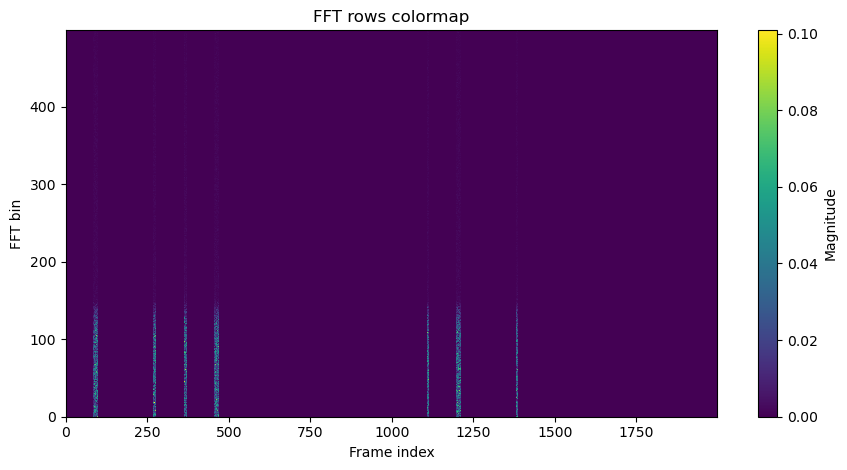

In [36]:
fig,ax=plot_fft_rows_colormap_freq_on_y(Per_channel_time_frequency_spectrum[2]['I'])
plt.show()

Doing Naive method

In [44]:
Wifi_naive_symbols={}
size_of_naive_samples_per_channel=100000

cur_num=0
for channel in Wifi_symbols:
    Wifi_naive_symbols[channel]={'I':[],'Q':[]}

while cur_num<total_samples:
    for channel in Wifi_symbols:
        for i in range(size_of_naive_samples_per_channel):
            Wifi_naive_symbols[channel]['I'].append((cur_num,Wifi_symbols[channel]['I'][cur_num]))
            Wifi_naive_symbols[channel]['Q'].append((cur_num,Wifi_symbols[channel]['Q'][cur_num]))
            cur_num+=1
        #cur_num+=size_of_naive_samples_per_channel
        if cur_num>=total_samples:
            break
#I = np.zeros(2_000_000, dtype=np.float64)  # force float64
print(Wifi_naive_symbols[1]['I'][:100])
#Wifi_naive_symbols[channel]['I'] = I  # ensure the mutated array is stored


[(0, 0.00024414322), (1, -9.155371e-05), (2, -0.00039673274), (3, -0.00070191175), (4, -0.00091553706), (5, -0.00094605493), (6, -0.0007934655), (7, -0.0005493222), (8, -0.0001525895), (9, 0.00012207161), (10, 0.00039673274), (11, 0.00070191175), (12, 0.00088501914), (13, 0.00088501914), (14, 0.0007934655), (15, 0.000610358), (16, 0.0002746611), (17, 0.0), (18, -0.0002746611), (19, -0.0006713938), (20, -0.00082398334), (21, -0.0007324297), (22, -0.00057984015), (23, -0.000305179), (24, 0.00012207161), (25, 0.00048828643), (26, 0.00070191175), (27, 0.0006713938), (28, 0.00039673274), (29, 3.0517902e-05), (30, -0.00036621484), (31, -0.00042725063), (32, -0.0003356969), (33, -6.1035804e-05), (34, 0.0003356969), (35, 0.00051880436), (36, 0.00064087595), (37, 0.00064087595), (38, 0.00057984015), (39, 0.0005493222), (40, 0.00070191175), (41, 0.00070191175), (42, 0.0007324297), (43, 0.000610358), (44, 0.00048828643), (45, 0.00012207161), (46, -0.00021362532), (47, -0.00039673274), (48, -0.000

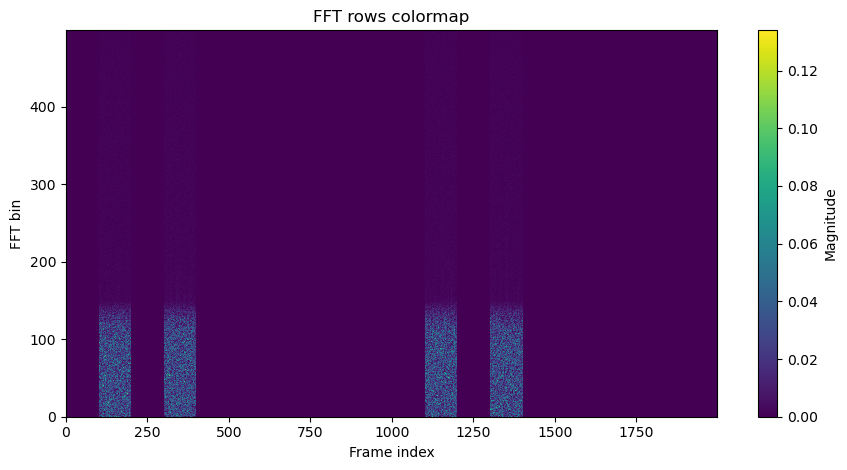

In [45]:
Wifi_output_data_after_interpolation_naive=interpolate_smartly(Wifi_naive_symbols)

Per_channel_time_frequency_spectrum={}

for channel in Wifi_symbols:
    Per_channel_time_frequency_spectrum[channel]={}
    I_f_t_spectrum=[]
    Q_f_t_spectrum=[]
    for i in range(num_fft-1):
        #print((i+1)*num_samples_per_fft)
        I_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation_naive[channel]['I'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
        Q_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation_naive[channel]['Q'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
    Per_channel_time_frequency_spectrum[channel]['I']=np.array(I_f_t_spectrum)
    Per_channel_time_frequency_spectrum[channel]['Q']=np.array(Q_f_t_spectrum)


fig,ax=plot_fft_rows_colormap_freq_on_y(Per_channel_time_frequency_spectrum[2]['I'])
plt.show()